## _Building Graphs: True Edges_

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
# sys.path.append('..')

# local imports
from src import draw_event
from src import compose_event

### _(+) - Input Data_

In [6]:
# mu- data (old)
# input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (current)
input_dir = './data_sets/pandaml/data_0.1_1.5_GeV/'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [8]:
# file_prefixes[:10]

In [9]:
event_id = 1
event_prefix = file_prefixes[event_id]

In [10]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.03 MB


In [11]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-12.2456,12.120,35.0,9,0,12
1,2,-13.1203,12.625,35.0,9,1,117
2,3,-13.9950,13.130,35.0,9,2,228
3,4,-13.9950,14.140,35.0,9,3,344
4,5,-14.8697,14.645,35.0,9,4,467


In [12]:
tubes.head()

,hit_id,isochrone,depcharge,energyloss,volume_id,layer_id,module_id,skewed,sector_id
0,1,0.262386,6000300.0,6.00030,9,0,12,0,0
1,2,0.052152,13722100.0,13.72210,9,1,117,0,0
2,3,0.374347,4073350.0,4.07335,9,2,228,0,0
3,4,0.265922,6590940.0,6.59094,9,3,344,0,0
4,5,0.085074,11615800.0,11.61580,9,4,467,0,0


In [13]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time
0,1,0.0,0.0,0.0,-0.134669,0.028540,-0.091022,1,25,13,0
1,2,0.0,0.0,0.0,-0.550762,-0.441498,0.780609,1,24,13,0
2,3,0.0,0.0,0.0,-0.072724,0.023378,0.175138,1,30,13,0
3,4,0.0,0.0,0.0,0.936311,-0.311491,-1.019850,1,24,13,0
4,5,0.0,0.0,0.0,-1.049040,-0.440627,0.471787,1,23,13,0


In [14]:
truth.head()

,hit_id,tx,ty,tz,tpx,tpy,tpz,weight,particle_id
0,1,-12.4533,11.9370,18.0376,-0.208362,0.236490,0.330727,1.0,10
1,2,-13.0823,12.6579,19.0411,-0.206470,0.238251,0.330621,1.0,10
2,3,-13.7024,13.3791,20.0387,-0.204324,0.239940,0.330703,1.0,10
3,4,-14.1996,13.9682,20.8477,-0.202521,0.241390,0.330725,1.0,10
4,5,-14.8052,14.6980,21.8424,-0.200172,0.243415,0.330639,1.0,10


### _(+) - Build Event_

- functions from _event_utils.py_

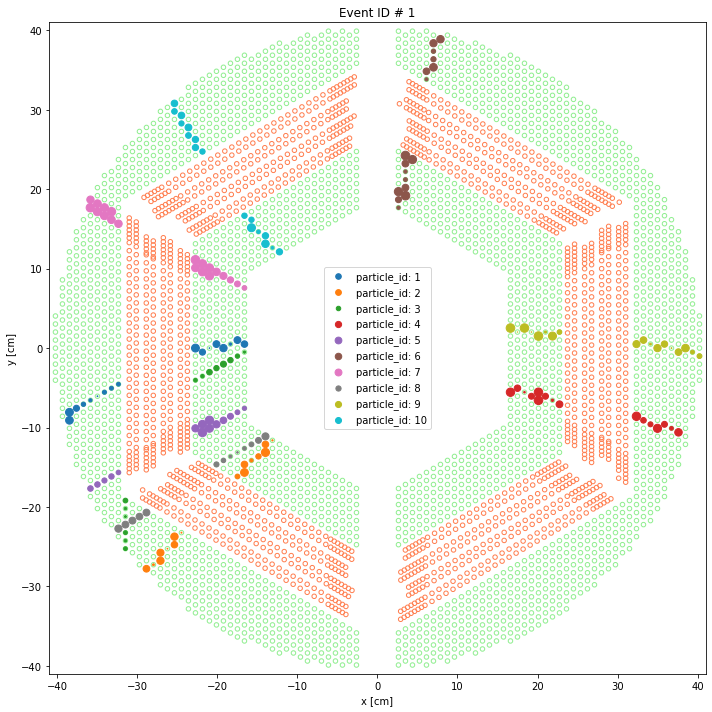

In [15]:
event = compose_event(event_prefix,skewed=False)
draw_event(event,figsize=(10, 10));

## _Build Graphs_

### _(A) - True Edges (Layerwise)_

**True Graph** is the ground truth for GNN. It is built from creating edges from _`hits`_ from the same particle but in adjacent layers. 

For this purpose one has _`true_edges, hits = get_layerwise_edges(event)`_ function in the _`event_util.py`_.

In [16]:
# true_edges, hits = get_layerwise_edges(event)

In [17]:
# EDA on get_layerwise_edges(event)
hits = event

In [18]:
hits = hits.assign(
        R=np.sqrt(
            (hits.x - hits.vx) ** 2 + (hits.y - hits.vy) ** 2 + (hits.z - hits.vz) ** 2
        )
    )

In [19]:
hits = hits.sort_values("R").reset_index(drop=True).reset_index(drop=False)

In [20]:
hits.loc[hits["particle_id"] == 0, "particle_id"] = np.nan

In [21]:
hit_list = (
        hits.groupby(["particle_id", "layer_id"], sort=False)["index"]
        .agg(lambda x: list(x))
        .groupby(level=0)
        .agg(lambda x: list(x))
    )

In [22]:
hit_list

particle_id
1.0     [[0], [5], [15], [24], [33], [44], [54], [63],...
2.0     [[7], [17], [23], [36], [46], [58], [66], [76]...
3.0     [[1], [6], [16], [27], [39], [48], [57], [70],...
4.0     [[4], [11], [21], [34], [43, 47], [53], [64], ...
5.0     [[14], [26], [37], [50], [59], [68, 71], [77, ...
6.0     [[9], [19], [29, 31], [40], [51], [61], [73], ...
7.0     [[13], [25], [38], [49], [60], [69, 72], [78, ...
8.0     [[10], [20], [30], [41], [55], [67], [79], [86...
9.0     [[2], [8], [18], [28], [35], [45], [56], [65],...
10.0    [[3], [12], [22], [32], [42], [52], [62], [74]...
Name: index, dtype: object

In [23]:
# get first row of hit list
row = hit_list.values[0]
row

[[0],
 [5],
 [15],
 [24],
 [33],
 [44],
 [54],
 [63],
 [89],
 [93],
 [99],
 [106],
 [116],
 [126],
 [138],
 [150, 154]]

In [24]:
# get elements of array from 0 to n-1 i.e. skipping the last element
row[0:-1]

[[0],
 [5],
 [15],
 [24],
 [33],
 [44],
 [54],
 [63],
 [89],
 [93],
 [99],
 [106],
 [116],
 [126],
 [138]]

In [25]:
# get elements of array from 1 to n i.e. skipping the first elemnet
row[1:]

[[5],
 [15],
 [24],
 [33],
 [44],
 [54],
 [63],
 [89],
 [93],
 [99],
 [106],
 [116],
 [126],
 [138],
 [150, 154]]

In [26]:
true_edges = []
for row in hit_list.values:
    for i, j in zip(row[0:-1], row[1:]): # row is list: we take 0 to n-1 elements as row[0:-1], and 1 to n as row[1:]
        true_edges.extend(list(itertools.product(i, j))) # extend() will add an iterable (list, set, etc) to the end of true_edges list, append() add one element to end of list.

In [27]:
true_edges = np.array(true_edges).T

* Now we have `true_edges` and corresponding `hits` (changed due to R parameter.)

In [28]:
# lets see how to access true_edges, 2D ndarray
true_edges

array([[  0,   5,  15,  24,  33,  44,  54,  63,  89,  93,  99, 106, 116,
        126, 138, 138,   7,  17,  23,  36,  46,  58,  66,  76,  94, 101,
        105, 114, 124, 136, 146,   1,   6,  16,  27,  39,  48,  57,  70,
        119, 127, 133, 142, 148, 156,   4,  11,  21,  34,  34,  43,  47,
         53,  64,  75,  92,  98, 104, 113, 123, 135,  14,  26,  37,  50,
         59,  59,  68,  68,  71,  71,  77,  81,  84, 111, 121, 131, 144,
          9,  19,  19,  29,  31,  40,  51,  61,  73,  73,  80,  83,  97,
        103, 112, 122, 134, 145,  13,  25,  38,  49,  60,  60,  69,  69,
         72,  72,  78,  78,  82,  82,  85,  87, 110, 110, 120, 120, 128,
        128, 132, 132, 139, 139, 143, 143, 152, 152,  10,  20,  30,  41,
         55,  67,  79,  86, 107, 117, 129, 141,   2,   8,  18,  28,  35,
         45,  56,  65,  88,  91,  96, 102, 109, 118, 130, 140, 151,   3,
         12,  22,  32,  42,  52,  62,  74,  90,  95, 100, 108, 115, 125,
        137, 149],
       [  5,  15,  24,  33,  44,

In [29]:
true_edges[0].size

171

In [30]:
true_edges[1].size

171

### _(+) - Plotting True Edges_

- I have hit pairs in two arrays
- Extract each pair (w/ `hit_id`) to plot
- How to plot hit pairs for one track?

In [31]:
# lets get unique pids with freq (~ hits).
sel_pids, sel_pids_fr = np.unique(hits.particle_id, return_counts=True)
print(sel_pids)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [32]:
# check size of true_edges
size = true_edges.shape[1]
print(size)

171


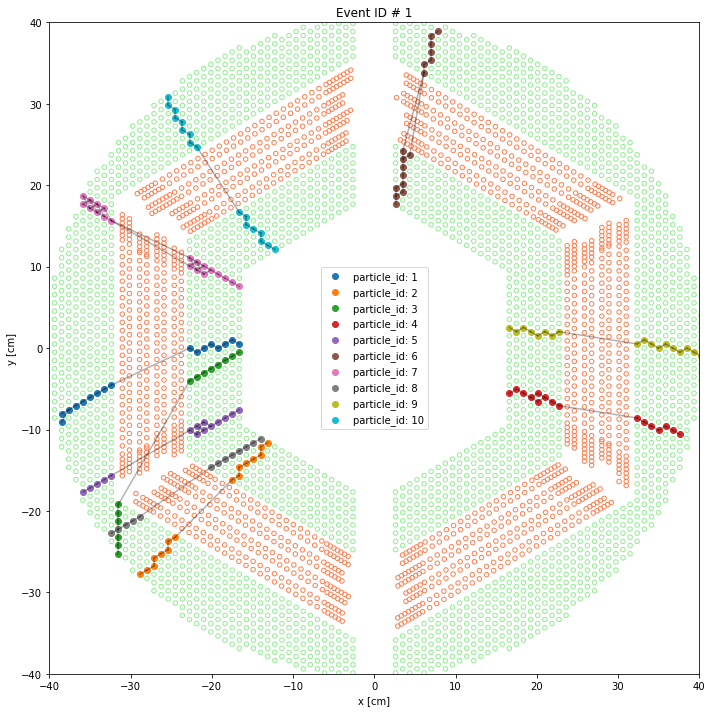

In [33]:
# plotting true_edges
plt.close('all')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

p_ids = np.unique(event.particle_id.values)
det = pd.read_csv("src/stt.csv")
skw = det.query('skewed==0')
nkw = det.query('skewed==1') # one look for +ve/-ve polarity

# detector layout
ax.scatter(skw.x.values, skw.y.values, s=20, facecolors='none', edgecolors='lightgreen')
ax.scatter(nkw.x.values, nkw.y.values, s=20, facecolors='none', edgecolors='coral')

# particle tracks
for pid in sel_pids:
    idx = hits.particle_id == pid
    ax.scatter(hits[idx].x.values, hits[idx].y.values, label='particle_id: %d' %pid)
    
# true edges
for iedge in range(true_edges.shape[1]):
    pt1 = hits.iloc[true_edges[0][iedge]]
    pt2 = hits.iloc[true_edges[1][iedge]]
    ax.plot([pt1.x, pt2.x], [pt1.y, pt2.y], color='k', alpha=0.3, lw=1.5)

ax.set_title('Event ID # %d' % event_id)
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.grid(False)
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_edges.png")